# Proyecto Final Statistical Learning I 

In [1]:
#Core
import numpy as np
import pandas as pd
import tensorflow as tf

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Scikit learn
from sklearn import tree
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
sns.set(style="ticks", color_codes=True)

#Carga del data set:
dataSet = pd.read_csv('data_titanic_proyecto.csv')

## Fase 0: Preparacion y exploracion de la data

En primer lugar, observamos que existen variables no numericas (incluso la variable a predecir) a la que se le tendra que aplicar one-hot encoding. 

Tambien, observamos que existen varios valores NaN y variables a que a primera vista, se observa que no aportaran nada al modelo debido a que no suponen una caracteristica general sino mas bien algo personal (como el nombre y el ID) por lo que seran eliminadas:

In [2]:
print(dataSet.shape)
dataSet.head(5)

(891, 12)


,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


In [3]:
dataSet.isna().sum()

PassengerId             0
Name                    0
Age                   177
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                2
passenger_class         0
passenger_sex           0
passenger_survived      0
dtype: int64

Una observacion preliminar descarta las Features de **Name** y **ID** por ser demasiado especificas. De igual forma, no tomaremos en cuenta la variable **Cabin** ya que mas del 75% (687/891) de sus valores son NaN. Otra variable que se considera muy especifica de cada pasajero es el **Ticket**. Para la variable **Embarked** dado que posee unicamente dos valores NaN, se obtara por eliminar dichas entradas. Con respecto a la variable **Age** de manera intuitiva, pareciera tener mucha significancia para ser eliminada por la cantidad de valores NaN (casi 20%), sin embargo, para poder dar una conclusion mas acertada acerca de si eliminamos esta variable o no, procedemos a una verificacion visual esporadica:

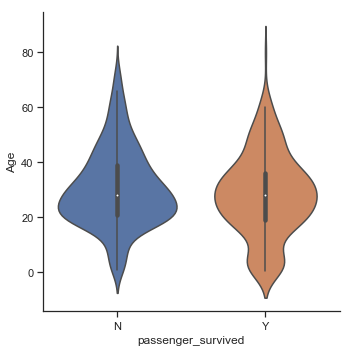

In [4]:
sns.catplot(y="Age", x="passenger_survived", kind="violin", data=dataSet)

Como se evidencia en las graficas de violin, la variable de la edad es significativa al momento de relalizar la evualuacion de si una persona sobre vive o no, por tanto no podemos desechar la variable ya que es significativa para el modelo. Tambien se eliminaran las variables que se consideran innecesarias o poco significativas para generar el modelo.

* **Reemplazo de valores NaN para la edad**.

Para solventar el problema de los datos faltantes, se aprovechara la media de las edades en el data set. Ademas para evitar la perdida de la variabilidad en el modelo utilizamos una medida de desviacion estandard para generar las edades de forma aleatoria manteniendo siempre una correlacion estadistica normal.

Fuentes: 

    https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
    https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html



PassengerId             0
Name                    0
Age                     0
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                2
passenger_class         0
passenger_sex           0
passenger_survived      0
dtype: int64


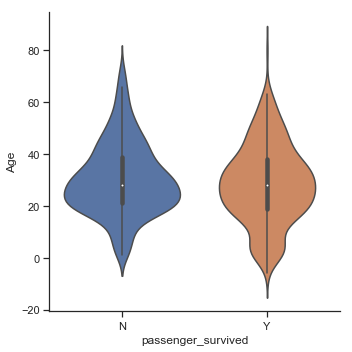

In [5]:
# Creacion del vector con las edades aleatorias que se utilizara para llenar los espacios en blanco.
fillAge = np.array(np.random.normal(dataSet['Age'].mean(), dataSet['Age'].std(),dataSet.isna().sum()['Age']),dtype =np.int)

#Creacion de un sub data frame en donde unicamente esta contenida la edad:
copyAge = dataSet["Age"].copy()

#Mutacion del data frame que contiene el los valores NaN.
copyAge[np.isnan(copyAge)] = fillAge
dataSet["Age"] = copyAge
print(dataSet.isna().sum())
sns.catplot(y="Age", x="passenger_survived", kind="violin", data=dataSet)

Como podemos apreciar, la feature **Age** ya no posee valores NaN y la grafica de Violin muestra que el metodo escogido se adapta de forma estable.

* **Supresion de variables y eliminacion de valores NaN (dos columnas)** 

In [6]:
dataSet = dataSet.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
dataSet = dataSet.dropna()
dataSet.head(10)

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,7.2500,S,Lower,M,N
1,38.0,1,0,71.2833,C,Upper,F,Y
2,26.0,0,0,7.9250,S,Lower,F,Y
3,35.0,1,0,53.1000,S,Upper,F,Y
4,35.0,0,0,8.0500,S,Lower,M,N
5,38.0,0,0,8.4583,Q,Lower,M,N
6,54.0,0,0,51.8625,S,Upper,M,N
7,2.0,3,1,21.0750,S,Lower,M,N
8,27.0,0,2,11.1333,S,Lower,F,Y
9,14.0,1,0,30.0708,C,Middle,F,Y


* **One-hot encoding**

Dado que aun tenemos variables no numericas, procedemos a la aplicacion de one-hot encoding no de la forma de agregar mas columnas (features) al dataset sino mas bien aplicando vaores enteros no necesariamente binarios (cuando asi lo requiera). Se adopta el siguiente convenio:

1) Si el pasajero sobrevive, se evalua con Y = 1, de lo contrario Y = 0.

2) Si el sexo del pasajero es masculino, X = 1, de lo contrario es X = 0.

3) Para los valores de Embarked se utilizaran los valores numericos 1,2 y 3 para los valores de string 'C', 'Q' y 'S' respectivamente.

4) Para los valores de passenger_class se utilizaran los valores 1, 2, 3 para sus contrapartes 'Lowr' 'Middle' y 'Upper' respectivamente.

In [7]:
# Aplicacino de condiciones: 
df_onehot = dataSet.copy()

df_onehot.loc[df_onehot.Embarked == 'C', 'embarked'] = 1 
df_onehot.loc[df_onehot.Embarked == 'Q', 'embarked'] = 2
df_onehot.loc[df_onehot.Embarked == 'S', 'embarked'] = 3

df_onehot.loc[df_onehot.passenger_class == 'Lower', 'class_pass'] = 1 
df_onehot.loc[df_onehot.passenger_class == 'Middle', 'class_pass'] = 2
df_onehot.loc[df_onehot.passenger_class == 'Upper', 'class_pass'] = 3

df_onehot.loc[df_onehot.passenger_sex == 'M', 'passenger_gender'] = 1 
df_onehot.loc[df_onehot.passenger_sex == 'F', 'passenger_gender'] = 0

df_onehot.loc[df_onehot.passenger_survived == 'Y', 'survived'] = 1 
df_onehot.loc[df_onehot.passenger_survived == 'N', 'survived'] = 0

df_onehot = df_onehot.drop(['Embarked','passenger_class','passenger_sex','passenger_survived'], axis=1)

* **Visualizacion de la data**

Continauando con nuestro analisis exploratorio de la data, procedemos con un poco de visualizacion entre la relacion de cada una de las features y la variable total a predecir.

Previo a la visualizcion, debemos darnos una idea (aunque sea general) de los posibles valores que pueden tomar las features. Sabemos por el one-hot encoding que las 4 variables que transformamos tienen valores discretos con un maximo de 3 posibles valores (para las variables de clase y embarque) y tambien tenemos una idea de los posibles valores de Age (muchos distintos posibles valores continuos), y Fare (muchos posibles valores discretos).  


Por tanto, unicamente queda explorar las variables SibSp y Parch.

In [8]:
print(df_onehot.SibSp.unique())
print(df_onehot.Parch.unique())
df_onehot.head(5)

[1 0 3 4 2 5 8]
[0 1 2 5 3 4 6]


,Age,SibSp,Parch,Fare,embarked,class_pass,passenger_gender,survived
0,22.0,1,0,7.2500,3.0,1.0,1.0,0.0
1,38.0,1,0,71.2833,1.0,3.0,0.0,1.0
2,26.0,0,0,7.9250,3.0,1.0,0.0,1.0
3,35.0,1,0,53.1000,3.0,3.0,0.0,1.0
4,35.0,0,0,8.0500,3.0,1.0,1.0,0.0


En base a esto ya podemos escoger el tipo de grafica que requerimos:

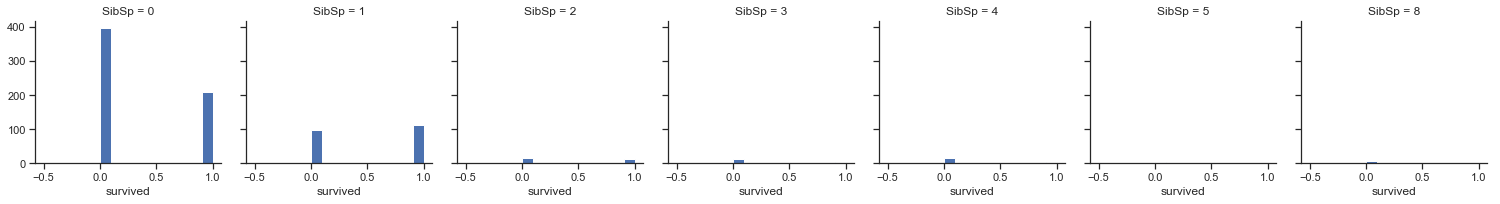

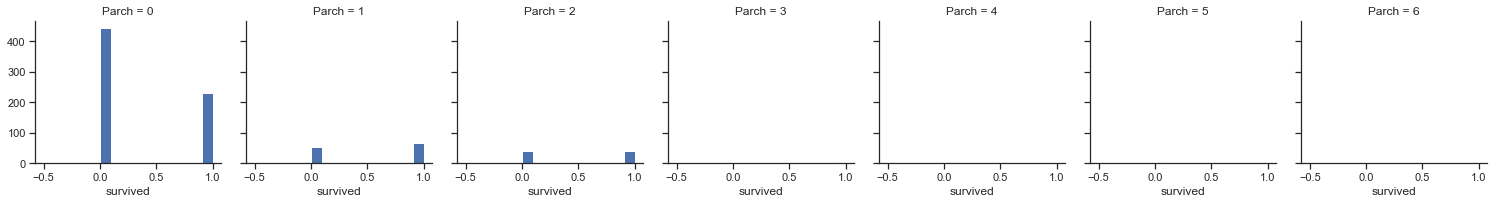

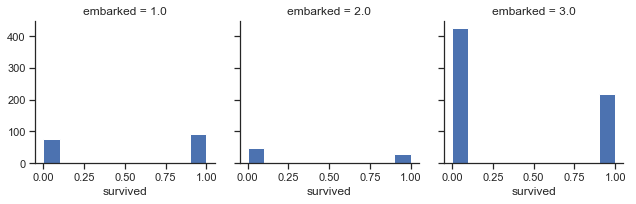

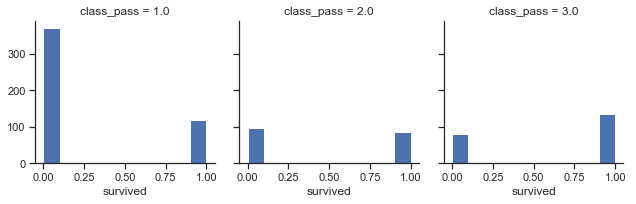

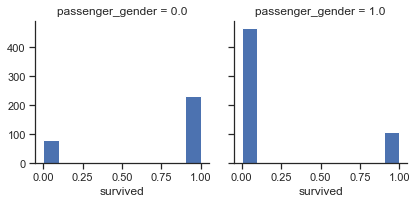

In [9]:
#Grafica de barras:
discreteFeatures = ['SibSp','Parch','embarked','class_pass','passenger_gender']
sns.set(style="ticks")
for ele in discreteFeatures:
    g = sns.FacetGrid(df_onehot, col=ele)
    g.map(plt.hist, "survived")

Ahora nos queda graficar las features no categoricas tanto discretas como continuas:

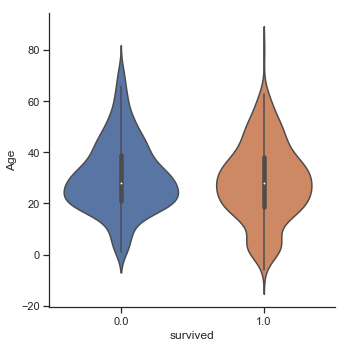

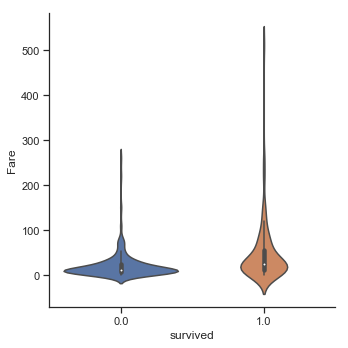

In [10]:
sns.catplot(y="Age", x="survived", kind="violin", data=df_onehot)
sns.catplot(y="Fare", x="survived", kind="violin", data=df_onehot)

Text(0, 0.5, 'Densidad')

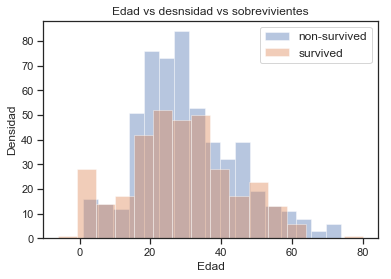

In [11]:
#Otra grafica para la Edad:
df = df_onehot[df_onehot.survived == 0.0]
sns.distplot(df['Age'],  kde=False, label='non-survived')

df =df_onehot[df_onehot.survived == 1.0]
sns.distplot(df['Age'],  kde=False,label='survived')

plt.legend(prop={'size': 12})
plt.title('Edad vs desnsidad vs sobrevivientes')
plt.xlabel('Edad')
plt.ylabel('Densidad')

Text(0, 0.5, 'Densidad')

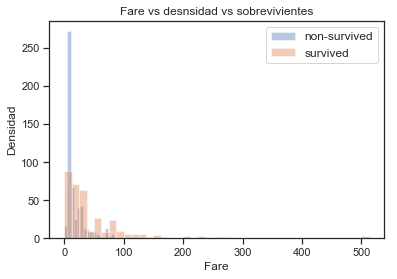

In [12]:
#Otra grafica para el Fare:
df = df_onehot[df_onehot.survived == 0.0]
sns.distplot(df['Fare'],  kde=False, label='non-survived')

df =df_onehot[df_onehot.survived == 1.0]
sns.distplot(df['Fare'],  kde=False,label='survived')

plt.legend(prop={'size': 12})
plt.title('Fare vs desnsidad vs sobrevivientes')
plt.xlabel('Fare')
plt.ylabel('Densidad')

*Nota de mencion: La razon por la que se grafico nuevamente la data de estas dos variables evaluando la densidad, es porque al momento de implementar el algoritmo de Neive-bayes me di cuenta que requeria que la data estuviera expresada como grupos discretos y no como valores continuos. Por tanto, se procedera a realizar la respectiva transformacion a estas dos variables*

* **Feature Engineering:**

**Agrupacion de variables continuas a grupos discretos (variables Fare y Age)**

Criterios de agrupacion:

1) Para la edad se tomarana los siguientes grupos:
    
    a) De 0 a 10 anios  -> Grupo 1
    b) De 10 a 17 anios -> Grupo 2
    c) De 17 a 25 anios -> Grupo 3
    d) De 25 a 35 anios -> Grupo 4
    e) De 35 a 45 anios -> Grupo 5
    f) De 45 a 60 anios -> Grupo 6
    e) De 60 anios en adelante -> Gurpo 7

In [13]:
df_onehot.loc[(df_onehot.Age<=10) , 'passAge'] = 1 
df_onehot.loc[(df_onehot['Age'] > 10) & (df_onehot['Age'] <= 17), 'passAge'] = 2
df_onehot.loc[(df_onehot['Age'] > 17) & (df_onehot['Age'] <= 25), 'passAge'] = 3
df_onehot.loc[(df_onehot['Age'] > 25) & (df_onehot['Age'] <= 35), 'passAge'] = 4
df_onehot.loc[(df_onehot['Age'] > 35) & (df_onehot['Age'] <= 45), 'passAge'] = 5
df_onehot.loc[(df_onehot['Age'] > 45) & (df_onehot['Age'] <= 60), 'passAge'] = 6
df_onehot.loc[(df_onehot.Age>60) , 'passAge'] = 7

1) Para la variable Fare se tomarana los siguientes grupos:
    
    a) De 0 a 40   -> Grupo 1
    b) De 40 a 60  -> Grupo 2
    c) De 60 a 90  -> Grupo 3
    d) De 90 a 140 -> Grupo 4
    e) De 140 en adelante -> 5

In [14]:
df_onehot.loc[(df_onehot.Fare<=40) , 'passFare'] = 1 
df_onehot.loc[(df_onehot['Fare'] > 40) & (df_onehot['Fare'] <= 60), 'passFare'] = 2
df_onehot.loc[(df_onehot['Fare'] > 60) & (df_onehot['Fare'] <= 90), 'passFare'] = 3
df_onehot.loc[(df_onehot['Fare'] > 90) & (df_onehot['Fare'] <= 140), 'passFare'] = 4
df_onehot.loc[(df_onehot.Fare>140) , 'passFare'] = 1 
df_onehot = df_onehot.drop(['Age','Fare'],axis=1)

df_onehot.head(10)

,SibSp,Parch,embarked,class_pass,passenger_gender,survived,passAge,passFare
0,1,0,3.0,1.0,1.0,0.0,3.0,1.0
1,1,0,1.0,3.0,0.0,1.0,5.0,3.0
2,0,0,3.0,1.0,0.0,1.0,4.0,1.0
3,1,0,3.0,3.0,0.0,1.0,4.0,2.0
4,0,0,3.0,1.0,1.0,0.0,4.0,1.0
5,0,0,2.0,1.0,1.0,0.0,5.0,1.0
6,0,0,3.0,3.0,1.0,0.0,6.0,2.0
7,3,1,3.0,1.0,1.0,0.0,1.0,1.0
8,0,2,3.0,1.0,0.0,1.0,4.0,1.0
9,1,0,1.0,2.0,0.0,1.0,2.0,1.0


**Combinacion de varibles**

Se procedera a combinar las variables 'SibSp' y 'Parch', de esta forma se reduciran el numero de Features, por tanto, vemos cual es la mejor forma de combinarlas:

In [15]:
#Realizamos pruebas sobre un dsata set incluyendo unicamente las dos variables a tratar:
SibParchMulti  = df_onehot[['SibSp','Parch','survived']].astype(float)
SibParchMulti['Values'] = SibParchMulti.SibSp*SibParchMulti.Parch
SibParchMulti.astype(bool).sum(axis=0)

SibSp       283
Parch       213
survived    340
Values      142
dtype: int64

Vemos que multiplicarlo pareciera no ser una buena opcion ya que la mayor parte de los valores de la nueva columna son ceros por lo que optamos por sumar los valores:

In [16]:
#Procedemos a multiplicar los valores del dataSet:
SibParchSuma  = df_onehot[['SibSp','Parch','survived']].astype(float)
SibParchSuma['Values'] = SibParchSuma.SibSp+SibParchSuma.Parch
SibParchSuma.astype(bool).sum(axis=0)

SibSp       283
Parch       213
survived    340
Values      354
dtype: int64

Vemos que esta transformacion nos brinda menos valores zero (mas valores no zero). Como criterio final de decision, proceder a realizar unas cuantas graficas:

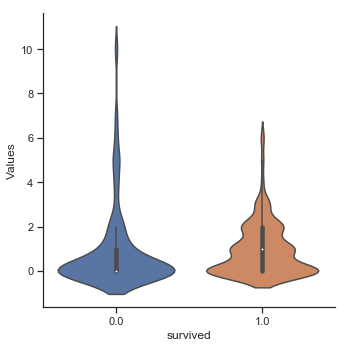

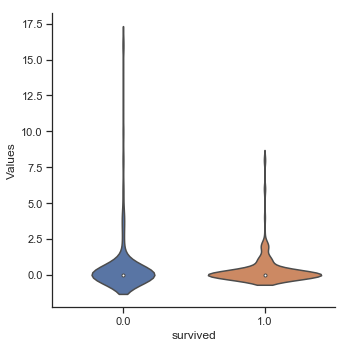

In [17]:
sns.catplot(x="survived", y="Values", kind="violin", data=SibParchSuma)
sns.catplot(x="survived", y="Values", kind="violin", data=SibParchMulti)

Basandonos en la parte del histograma creado por la grafica de violin, cuando multiplicamos la data parecieramos tener una distribucion normal para ambos resultados con una media muy cercana a zero, eso es entendible porque la mayoria de los valores son de zero, vemos tambien que cuando la data se suma obtenemos valores mas dispersos. Por tanto, tomamos la suma de las variables para crear una nueva feature y procedemos con la suprecion de las otras dos.

In [18]:
df_onehot["SibParchSum"] =  df_onehot.SibSp+df_onehot.Parch

In [19]:
df_onehot = df_onehot.drop(['SibSp','Parch'],axis=1)
df_onehot['SibParchSum'] = df_onehot['SibParchSum'].astype(float)
df_onehot.head(5)

,embarked,class_pass,passenger_gender,survived,passAge,passFare,SibParchSum
0,3.0,1.0,1.0,0.0,3.0,1.0,1.0
1,1.0,3.0,0.0,1.0,5.0,3.0,1.0
2,3.0,1.0,0.0,1.0,4.0,1.0,0.0
3,3.0,3.0,0.0,1.0,4.0,2.0,1.0
4,3.0,1.0,1.0,0.0,4.0,1.0,0.0


**Escalamiento/normalizacin de las features: Aplicacion de la formula: x' =  (x - xmin)/(xmax - xmin)**

In [20]:
scaling = preprocessing.MinMaxScaler()
scaledMatrix = scaling.fit_transform(df_onehot)
df_normalized = pd.DataFrame(scaledMatrix,columns=df_onehot.columns)
df_normalized.head(5)

,embarked,class_pass,passenger_gender,survived,passAge,passFare,SibParchSum
0,1.0,0.0,1.0,0.0,0.333333,0.000000,0.1
1,0.0,1.0,0.0,1.0,0.666667,0.666667,0.1
2,1.0,0.0,0.0,1.0,0.500000,0.000000,0.0
3,1.0,1.0,0.0,1.0,0.500000,0.333333,0.1
4,1.0,0.0,1.0,0.0,0.500000,0.000000,0.0


* **Data Split (train, test, validation)**

Se tomaran un 20% de datos para test, un 85% de datos para train y de ese 80% se tomara un 15% de datos para validacion.

In [21]:
xTrain, xPreTest, yTrain, yPreTest = train_test_split(df_normalized[['passAge','passFare','embarked','class_pass','passenger_gender','SibParchSum']],
                                                    df_normalized[['survived']], 
                                                    test_size=0.30)
xTest, xVal, yTest, yVal = train_test_split(xPreTest, yPreTest, test_size=0.35)

In [22]:
print(df_normalized.shape)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
print(xVal.shape)
print(yVal.shape)

(889, 7)
(622, 6)
(622, 1)
(173, 6)
(173, 1)
(94, 6)
(94, 1)


In [23]:
xTrain.columns

Index(['passAge', 'passFare', 'embarked', 'class_pass', 'passenger_gender',
       'SibParchSum'],
      dtype='object')

Se dividen los datos con aproximadamente la siguiente distribucion:

1) Entrenamiento 70%

2) Prueba 20%

3) Validacion 10%

## Fase 1: Creacion de modelos.

* **Desicion Trees Model (Scikit learn)**

Dado que este es un algoritmo no parametrico, no es necesario crear una bitacora con el record de parametros como tal, unicamente se tomaran las metricas que genera el modelo:

In [24]:
models= []
def dt(X=xTrain,Y=yTrain):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, Y)
    return clf
models.append(dt)

In [25]:
#Realizamos las prediccione sobre el dataset de pruebas:
dtPredictions = models[0]().predict(xTest)
dtPredictions

array([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0.])

In [78]:
#Accuracy
np.count_nonzero(np.array(np.equal(dtPredictions,np.reshape(np.asanyarray(yTest),yTest.shape[0])),int))/yTest.shape[0]

0.8208092485549133

* **Support Vector Machines (Scikit learn)**:

In [34]:
def svmAlg(X=xTrain,Y=yTrain):
    clf = svm.SVC(gamma='scale')
    clf.fit(xTrain,
            np.reshape(np.asanyarray(Y),Y.shape[0]))
    return clf
models.append(svmAlg)

In [35]:
svmPredictions = models[1]().predict(xTest)

In [36]:
svmPredictions

array([0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0.])

In [79]:
#Acuraccy
np.count_nonzero(np.array(np.equal(svmPredictions,np.reshape(np.asanyarray(yTest),yTest.shape[0])),int))/yTest.shape[0]

0.8208092485549133

* **Naive Bayes**

Para la implementacion de este algoritmo, lo que debemos hacer es tener la data dividida en grupos. Para esto, nos quedan dos features por "grupalizar".

In [94]:
totalSurvived = int(yTest.astype(bool).sum(axis=0))
totalNonSurv = len(yTest) - totalSurvived
#print(totalSurvived)
#print(totalNonSurv)

Tabla de frecuencia y probabilidad para la edad:

In [95]:
survived_age = pd.crosstab(columns=yTest["survived"], index=xTest["passAge"])
survived_age.columns= ["non_survived","survived"]
survived_age["Total"] = survived_age.non_survived + survived_age.survived
#survived_age

In [96]:
survived_age["non_survived"] = survived_age.non_survived/totalNonSurv
survived_age["survived"] = survived_age.survived/totalSurvived
survived_age["Total"] = survived_age.Total/(totalSurvived+totalNonSurv)
survived_age

,non_survived,survived,Total
passAge,,,
0.000000,0.081081,0.129032,0.098266
0.166667,0.072072,0.048387,0.063584
0.333333,0.324324,0.193548,0.277457
0.500000,0.288288,0.322581,0.300578
0.666667,0.126126,0.145161,0.132948
0.833333,0.063063,0.145161,0.092486
1.000000,0.045045,0.016129,0.034682


Tabla de frecuencia y probabilidad para la variable Fare:

In [81]:
survived_fare = pd.crosstab(columns=yTest["survived"], index=xTest["passFare"])
survived_fare.columns= ["non_survived","survived"]
survived_fare["Total"] = survived_fare.non_survived + survived_fare.survived
#survived_fare

survived_fare["non_survived"] = survived_fare.non_survived/totalNonSurv
survived_fare["survived"] = survived_fare.survived/totalSurvived
survived_fare["Total"] = survived_fare.Total/(totalSurvived+totalNonSurv)
survived_fare

,non_survived,survived,Total
passFare,,,
0.000000,0.882883,0.758065,0.838150
0.333333,0.036036,0.129032,0.069364
0.666667,0.081081,0.048387,0.069364
1.000000,0.000000,0.064516,0.023121


Tabla de frecuencia y probabilidad para la variable embarked:

In [87]:
survived_embarked = pd.crosstab(columns=yTest["survived"], index=xTest["embarked"])
survived_embarked.columns= ["non_survived","survived"]
survived_embarked["Total"] = survived_embarked.non_survived + survived_embarked.survived
#survived_embarked

survived_embarked["non_survived"] = survived_embarked.non_survived/totalNonSurv
survived_embarked["survived"] = survived_embarked.survived/totalSurvived
survived_embarked["Total"] = survived_embarked.Total/(totalSurvived+totalNonSurv)
survived_embarked

,non_survived,survived,Total
embarked,,,
0.0,0.099099,0.322581,0.179191
0.5,0.063063,0.064516,0.063584
1.0,0.837838,0.612903,0.757225


Tabla de frecuencia y probabilidad para la variable clase:

In [88]:
survived_class_pass = pd.crosstab(columns=yTest["survived"], index=xTest["class_pass"])
survived_class_pass.columns= ["non_survived","survived"]
survived_class_pass["Total"] = survived_class_pass.non_survived + survived_class_pass.survived
#survived_class_pass

survived_class_pass["non_survived"] = survived_class_pass.non_survived/totalNonSurv
survived_class_pass["survived"] = survived_class_pass.survived/totalSurvived
survived_class_pass["Total"] = survived_class_pass.Total/(totalSurvived+totalNonSurv)
survived_class_pass

,non_survived,survived,Total
class_pass,,,
0.0,0.675676,0.306452,0.543353
0.5,0.180180,0.290323,0.219653
1.0,0.144144,0.403226,0.236994


Tabla de frecuencia y probabilidad para la variable sexo:

In [93]:
survived_passenger_gender = pd.crosstab(columns=yTest["survived"], index=xTest["passenger_gender"])
survived_passenger_gender.columns= ["non_survived","survived"]
survived_passenger_gender["Total"] = survived_passenger_gender.non_survived + survived_passenger_gender.survived
#survived_passenger_gender

survived_passenger_gender["non_survived"] = survived_passenger_gender.non_survived/totalNonSurv
survived_passenger_gender["survived"] = survived_passenger_gender.survived/totalSurvived
survived_passenger_gender["Total"] = survived_passenger_gender.Total/(totalSurvived+totalNonSurv)
survived_passenger_gender

,non_survived,survived,Total
passenger_gender,,,
0.0,0.153153,0.645161,0.32948
1.0,0.846847,0.354839,0.67052


Tabla de frecuencia y probabilidad para la variable combinada SibParchSum:

In [90]:
survived_SibParchSum = pd.crosstab(columns=yTest["survived"], index=xTest["SibParchSum"])
survived_SibParchSum.columns= ["non_survived","survived"]
survived_SibParchSum["Total"] = survived_SibParchSum.non_survived + survived_SibParchSum.survived
#survived_SibParchSum

survived_SibParchSum["non_survived"] = survived_SibParchSum.non_survived/totalNonSurv
survived_SibParchSum["survived"] = survived_SibParchSum.survived/totalSurvived
survived_SibParchSum["Total"] = survived_SibParchSum.Total/(totalSurvived+totalNonSurv)
survived_SibParchSum

,non_survived,survived,Total
SibParchSum,,,
0.0,0.657658,0.467742,0.589595
0.1,0.162162,0.241935,0.190751
0.2,0.054054,0.145161,0.086705
0.3,0.018018,0.112903,0.052023
0.4,0.036036,0.016129,0.028902
0.5,0.027027,0.000000,0.017341
0.6,0.027027,0.016129,0.023121
1.0,0.018018,0.000000,0.011561
